Author: Bram van Duinen

Date: 15 nov 2023

Content: Loading in demand data, and detecting 1-in-10 year events with high residual load per country. Calculating co-occurences of max residual load per run in-between countries. Output is saved and re-used in plot_co-occurencemaps.ipynb

In [285]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap
import colorcet as cc
import seaborn as sns
import itertools
from tqdm.notebook import tqdm
import pandas as pd

In [286]:
from mappings import df_countries

In [287]:
daily = '/net/pc200256/nobackup/users/most/LENTIS/present/day/'
energy = '/net/pc200256/nobackup/users/most/output/LENTIS_PD_02/agg_production/per_country/'

In [288]:
def add_filename(ds):
    # Extract the filename from the 'source' attribute, which is automatically set by open_mfdataset
    filename = os.path.basename(ds.encoding['source'])
    
    # Extract the characters that match the '???' part of the filename
    identifier = filename.split('_')[0]
    
    # Add the identifier as a new coordinate to the dataset
    ds = ds.assign_coords(country_name=identifier)
    
    return ds

data_prod = xr.open_mfdataset(energy + '???' + '_LENTIS_PD_02_v4.nc', combine='nested', concat_dim='country', preprocess=add_filename)

num_countries = np.shape(data_prod.residual)[0]

In [297]:
countries = data_prod.country_name.values

In [290]:
quantile_val = 0.9997260274
quant = data_prod.residual.quantile(quantile_val, dim = ['time', 'runs'], keep_attrs = True).compute()
events = data_prod.where(data_prod.residual >= quant)

In [291]:
data_prod_stack = data_prod.stack(event=('time', 'runs'))
sorted_indices = (-data_prod_stack.residual.compute()).argsort()

In [292]:
num_events = 160 #1-in-10 year events
num_countries = 24 #hardcode

# Initialize empty lists for residuals, runs, and times
top_residuals = np.empty((num_countries, num_events))
top_times = np.empty((num_countries, num_events), dtype='M8[ns]')
top_runs = np.full((num_countries, num_events), '', dtype=object)


# Iterate over each country
for country in tqdm(range(num_countries)):
#for country in range(2):
    eventnr = 0
    begin_ind = 0
    end_ind = 3000 #3000 #initially try 3000 options to find 160 events per country

    while eventnr < num_events:
        # Get the top num_events indices for this country
        top_indices = sorted_indices[country, begin_ind:end_ind].values

        # Get the corresponding residuals, runs, and times
        residuals = data_prod_stack.residual[country, top_indices].values
        runs = data_prod_stack.runs[top_indices].values
        times = data_prod_stack.time[top_indices].values

        for i, t in enumerate(times):
            event = (t, runs[i])
            if runs[i] not in top_runs[country,:]:
                top_residuals[country, eventnr] = residuals[i]
                top_times[country, eventnr] = t
                top_runs[country, eventnr] = runs[i]
                eventnr += 1
            else:
                samerun = np.where(runs[i] == top_runs[country,:])[0]
                dt = abs(t - top_times[country, samerun])
                if all(dt > np.timedelta64(7, 'D')):
                    dt_d = dt.astype('timedelta64[D]')
                    top_residuals[country, eventnr] = residuals[i]
                    top_times[country, eventnr] = t
                    top_runs[country, eventnr] = runs[i]
                    eventnr += 1
            if eventnr == num_events:
                break
        begin_ind = end_ind
        end_ind += 100 #3000

ds_events = xr.Dataset(
    {
        'residual': (('country', 'event_nr'), top_residuals),
        'time': (('country', 'event_nr'), top_times),
        'run': (('country', 'event_nr'), top_runs)
    },
    coords={
        'country': countries,
        'event_nr': np.arange(num_events)
    }
) 

  0%|          | 0/24 [00:00<?, ?it/s]

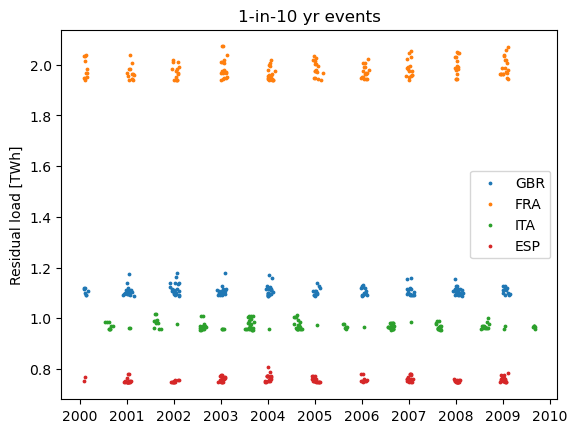

In [293]:
country_ind = 8 #United Kingdom
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

country_ind = 7 #France
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

country_ind = 12 #Italy
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

country_ind = 5 #Spain
plt.scatter(ds_events.time[country_ind], ds_events.residual[country_ind]/1e6, label = countries[country_ind], s = 3)

# Set the labels and title
plt.ylabel('Residual load [TWh]')
plt.title(f'1-in-10 yr events')
plt.legend()

([<matplotlib.axis.XTick at 0x7f5a43a2bcd0>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Feb'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Apr'),
  Text(5, 0, 'May'),
  Text(6, 0, 'Jun'),
  Text(7, 0, 'Jul'),
  Text(8, 0, 'Aug'),
  Text(9, 0, 'Sep'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Dec')])

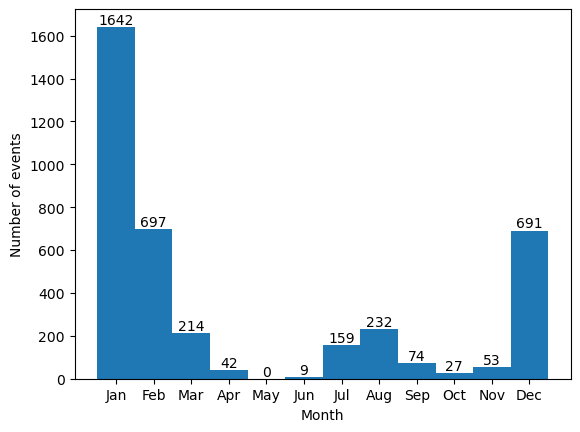

In [294]:
months = ds_events.time.dt.month.values.flatten()
#make a histogram of months
counts, edges, bars = plt.hist(months, bins=np.linspace(0.5,12.5, 13))
plt.xlabel('Month')
plt.bar_label(bars)
plt.ylabel('Number of events')
# make xticks the month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1,13), month_names)

In [295]:
# Initialize a DataArray to store the co-occurrences
co_occurrences = xr.DataArray(
    np.zeros((len(countries), len(countries)), dtype=int),
    coords={'country_1': countries, 'country_2': countries},
    dims=['country_1', 'country_2']
)

co_occurrences = np.zeros((num_countries, num_countries), dtype=float)


for country_1, country_2 in tqdm(itertools.product(ds_events.country.values, repeat=2)):
    # print(country_1, country_2)
    id_country_1 = np.where(countries == country_1)[0][0]
    id_country_2 = np.where(countries == country_2)[0][0]
    for i in range(num_events):
        dt = np.abs(ds_events.time.sel(country=country_2) - ds_events.time.sel(country=country_1).values[i])
        timeok = dt <= np.timedelta64(7, 'D')
        run_1 = ds_events.run.sel(country=country_1)[i]
        run_2 = ds_events.run.sel(country=country_2).where(timeok)
        co_occurrences[id_country_1, id_country_2] += np.sum(run_1 == run_2).values

0it [00:00, ?it/s]

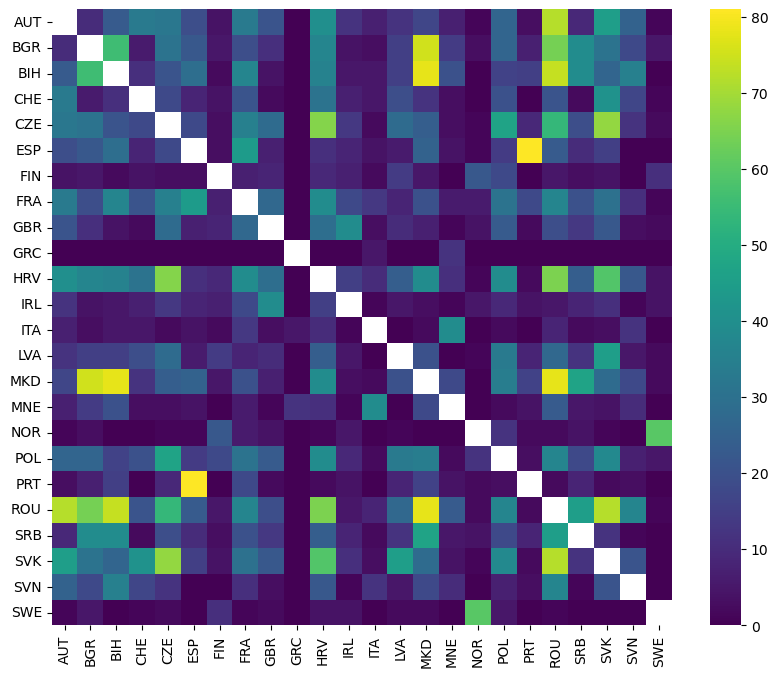

In [301]:
# Sum up the co-occurrences over all runs
co_occurrences = xr.DataArray(
    co_occurrences,
    coords={'country_1': countries, 'country_2': countries},
    dims=['country_1', 'country_2']
)

np.fill_diagonal(co_occurrences.values, np.nan)

plt.figure(figsize=(10, 8))

sns.heatmap(co_occurrences, cmap='viridis')
# Now make the xticks the country identifiers from country_name
plt.xticks(np.arange(num_countries) + 0.5, countries, rotation=90)
plt.yticks(np.arange(num_countries) + 0.5, countries, rotation=0)
plt.show()

In [305]:
np.save('../Results/co_occurrences.npy', co_occurrences.values)